Kareem Amr Otafy 19/05471
Mohamed Amr 19/05441

# Declarations

In [1]:
# Importing necessary libraries
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import imutils
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from tabulate import tabulate

# Setting the image size for resizing
image_size = 28

def flatten_image(image):
    """
    Flatten the 2D input image into a 1D array.

    Parameters:
    - image: Input image (2D numpy array)

    Returns:
    - flattened_image: 1D numpy array
    """
    return np.array(image).flatten()

def flatten_images(images):
    """
    Flatten a list of 2D images into a 2D array of flattened images.

    Parameters:
    - images: List of input images (2D numpy arrays)

    Returns:
    - flattened_images: 2D numpy array
    """
    return np.array([flatten_image(image) for image in images])

def read_image(class_path, image_file):
    """
    Read and preprocess an image from a specified path.

    Parameters:
    - class_path: Path to the directory containing the image
    - image_file: Filename of the image

    Returns:
    - image: Preprocessed and resized grayscale image (2D numpy array)
    """
    image_path = os.path.join(class_path, image_file)
    image =  cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    return image

def apply_sobel(image):
    """
    Apply Sobel edge detection to the input image and extract directional gradient features.

    Parameters:
    - image: Input grayscale image (2D numpy array)

    Returns:
    - directional_images: List of flattened 8 directional gradient images
    """
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gx**2 + gy**2)
    gradient_angle = np.arctan2(gy, gx)
    quantized_angles = (np.round((gradient_angle + np.pi) / (np.pi / 4)) % 8).astype(int)
    directional_images = [np.zeros_like(image) for _ in range(8)]

    for i in range(8):
        directional_images[i][quantized_angles == i] = gradient_magnitude[quantized_angles == i]
        directional_images[i] = flatten_image(directional_images[i])
    
    return directional_images


## Loading Dataset

In [2]:
# Creating empty lists to store class labels and images
class_labels_list = []
images_list = []

# Path to the dataset directory
data_directory = './dataset/'

# List of class directories in the dataset
directories = os.listdir(data_directory)

# Loop through each class directory
for class_label, class_name in enumerate(directories):
    class_path = os.path.join(data_directory, class_name)
    
    # Loop through each image file in the class directory
    for image_file in os.listdir(class_path):
        # Check if the file is a JPEG image
        if image_file.endswith('.jpg'):
            # Read and preprocess the image
            image = read_image(class_path, image_file)
            
            # Append the image and its corresponding class label to the lists
            images_list.append(image)
            class_labels_list.append(class_label)

# Separate data into feature vectors (X) and class labels (y)
data_x = images_list
data_y = class_labels_list

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, 
                                                    test_size=0.25, 
                                                    random_state=13)


## Sobel

In [3]:
# Apply Sobel edge detection to each image in the training set and flatten the resulting directional gradient images
x_train_sobel = [flatten_image(apply_sobel(image)) for image in X_train]
x_test_sobel = [flatten_image(apply_sobel(image)) for image in X_test]


In [4]:
# Define, fit, predict, and accuracy functions for the KNN classifier

sobel_knn_classifier = KNeighborsClassifier(n_neighbors=15)
sobel_knn_classifier.fit(x_train_sobel, y_train)
sobel_knn_predictions = sobel_knn_classifier.predict(x_test_sobel)
sobel_knn_accuracy = accuracy_score(y_test, sobel_knn_predictions)
print("Accuracy of KNN-Sobel Classifier: ", sobel_knn_accuracy)


Accuracy of KNN-Sobel Classifier:  0.5643115942028986


In [5]:
# Define, fit, predict, and accuracy functions for the SVM classifier

sobel_svm_classifier = SVC(kernel='rbf', probability=True, C=100)
sobel_svm_classifier.fit(x_train_sobel, y_train)
sobel_svm_predictions = sobel_svm_classifier.predict(x_test_sobel)
sobel_svm_accuracy = accuracy_score(y_test, sobel_svm_predictions)
print("Accuracy of SVM-Sobel classifier:", sobel_svm_accuracy)

Accuracy of SVM-Sobel classifier: 0.8152173913043478


## PCA

In [5]:
# Apply PCA to the training and testing sets

X_train_flatten = flatten_images(X_train)
X_test_flatten = flatten_images(X_test)

pca = PCA(n_components=64).fit(X_train_flatten)
X_train_pca = pca.transform(X_train_flatten)
X_test_pca = pca.transform(X_test_flatten)

In [6]:
# Define, fit, predict, and accuracy functions for the KNN classifier

pca_knn_classifier = KNeighborsClassifier(n_neighbors=15) 
pca_knn_classifier.fit(X_train_pca, y_train)
pca_knn_predictions = pca_knn_classifier.predict(X_test_pca)
pca_knn_accuracy = accuracy_score(y_test, pca_knn_predictions)
print("Accuracy of KNN-PCA Classifier:", pca_knn_accuracy)

Accuracy of KNN-PCA Classifier: 0.7182971014492754


In [7]:
# Define, fit, predict, and accuracy functions for the SVM classifier

pca_svm_classifier = SVC(kernel='rbf', probability=True,C=100)
pca_svm_classifier.fit(X_train_pca, y_train)
pca_svm_predictions = pca_svm_classifier.predict(X_test_pca)
pca_svm_accuracy = accuracy_score(y_test, pca_svm_predictions)
print("Accuracy of SVM-PCA Classifier:", pca_svm_accuracy)

Accuracy of SVM-PCA Classifier: 0.8596014492753623


## Additional Classifier: Random Forest

In [8]:
# Define, fit, predict, and accuracy functions for the Random Forest classifier

pca_rf_model = RandomForestClassifier(n_estimators=140, random_state=42)
pca_rf_model.fit(X_train_pca, y_train)
y_pred = pca_rf_model.predict(X_test_pca)
pca_rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of RF-PCA Classifier:", pca_rf_accuracy)

Accuracy of RF-PCA Classifier: 0.7445652173913043


In [9]:
# Define, fit, predict, and accuracy functions for the Random Forest classifier

sobel_rf_model = RandomForestClassifier(n_estimators=160, random_state=42)
sobel_rf_model.fit(x_train_sobel, y_train)
y_pred = sobel_rf_model.predict(x_test_sobel)
sobel_rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of RF-Sobel Classifier:", sobel_rf_accuracy)

Accuracy of RF-Sobel Classifier: 0.7436594202898551


JFhN4MIfNGL
JEAN-MICHEL


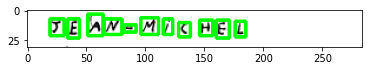

In [11]:
# Define the machine learning model to be used for letter recognition
model = sobel_rf_model
def sort_contours(cnts, method="left-to-right"):
    """
    Sort contours based on a specified method.

    Parameters:
    - cnts: List of contours
    - method: Sorting method ("left-to-right", "right-to-left", "top-to-bottom", or "bottom-to-top")

    Returns:
    - Tuple containing sorted contours and their bounding boxes
    """
    reverse = False
    i = 0

    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # Extract bounding boxes for each contour
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]

    # Sort contours and bounding boxes based on the specified method
    (cnts, boundingBoxes) = zip(
        *sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse)
    )

    # Return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)



def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Invert image from white background with black text to black background with white text 
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    # Apply dilation to make letters more clear
    dilated = cv2.dilate(thresh1, None, iterations=2)
    # Find contours of letters
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Extract contours
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            # Draw rectangle around contour in original image
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        #Extract each letter and resize it to 28x28 pixels with thresholding applied
        roi = gray[y : y + h, x : x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (image_size,image_size))
        # Apply model specific transformation
        # thresh = pca.transform([flatten_image(thresh)])
        thresh =  [flatten_image(apply_sobel(thresh))] 
        ypred = model.predict(thresh)
        [x] = ypred
        letters.append(x)
    return letters, image


def get_word(letters):
    """
    Reconstruct a word from a list of predicted letters.

    Parameters:
    - letters: List of predicted letter class labels

    Returns:
    - Reconstructed word as a string
    """
    word = ''
    for letter in letters:
        word += directories[letter]
    return word

    


letters, image = get_letters(
    "../AIProject/2.jpg"
)

word = get_word(letters)


import re
def transform_string(input_string):
    """
    Transform a string based on a specified pattern as lower case letters are specified as @_.

    Parameters:
    - input_string: Input string to be transformed

    Returns:
    - Transformed string
    """
    pattern = r'@_([A-Z])'
    
    # Replace matched patterns by converting the uppercase letter to lowercase
    result = re.sub(pattern, lambda match: match.group(1).lower(), input_string)
    
    # Remove any remaining occurrences of '@_'
    result = result.replace('@_', '')
    
    return result



print(transform_string(word))
print("JEAN-MICHEL")
plt.imshow(image)

# Base Metrics

In [12]:
# Calculate the area under the ROC curve for each classifier/ feature extraction method

pca_knn_probabilities = pca_knn_classifier.predict_proba(X_test_pca)
pca_knn_auc = roc_auc_score(y_test, pca_knn_probabilities, multi_class='ovr')
print("Area Under the Curve (AUC) for KNN-PCA classifier:", pca_knn_auc)

pca_svm_probabilities = pca_svm_classifier.predict_proba(X_test_pca)
pca_svm_auc = roc_auc_score(y_test, pca_svm_probabilities, multi_class='ovr')
print("Area Under the Curve (AUC) for SVM-PCA classifier:", pca_svm_auc)

sobel_knn_probabilities = sobel_knn_classifier.predict_proba(x_test_sobel)
sobel_knn_auc = roc_auc_score(y_test, sobel_knn_probabilities, multi_class='ovr')
print("Area Under the Curve (AUC) for KNN-Sobel classifier:", sobel_knn_auc)

sobel_svm_probabilities = sobel_svm_classifier.predict_proba(x_test_sobel)
sobel_svm_auc = roc_auc_score(y_test, sobel_svm_probabilities, multi_class='ovr')
print("Area Under the Curve (AUC) for SVM-Sobel classifier:", sobel_svm_auc)

sobel_rf_probabilities = sobel_rf_model.predict_proba(x_test_sobel)
sobel_svm_auc = roc_auc_score(y_test, sobel_rf_probabilities, multi_class='ovr')
print("Area Under the Curve (AUC) for RF-Sobel classifier:", sobel_svm_auc)

pca_rf_probabilities = pca_rf_model.predict_proba(X_test_pca)
sobel_svm_auc = roc_auc_score(y_test, pca_rf_probabilities, multi_class='ovr')
print("Area Under the Curve (AUC) for RF-Sobel classifier:", sobel_svm_auc)


Area Under the Curve (AUC) for KNN-PCA classifier: 0.9824512825712063
Area Under the Curve (AUC) for SVM-PCA classifier: 0.9953672240691946
Area Under the Curve (AUC) for KNN-Sobel classifier: 0.9438729258133381
Area Under the Curve (AUC) for SVM-Sobel classifier: 0.9946413905621188
Area Under the Curve (AUC) for RF-Sobel classifier: 0.9841878529157969
Area Under the Curve (AUC) for RF-Sobel classifier: 0.9814887580433457


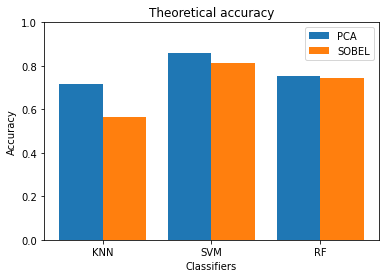

In [13]:
# Plot the theoretical accuracy of each classifier/ feature extraction method

X = ['KNN','SVM','RF'] 
PCA = [pca_knn_accuracy,pca_svm_accuracy,pca_rf_accuracy] 
SOBEL = [sobel_knn_accuracy,sobel_svm_accuracy,sobel_rf_accuracy] 
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, PCA, 0.4, label = 'PCA' ) 
plt.bar(X_axis + 0.2, SOBEL, 0.4, label = 'SOBEL') 

plt.ylim(0, 1)  

plt.xticks(X_axis, X) 
plt.xlabel("Classifiers") 
plt.ylabel("Accuracy") 
plt.title("Theoretical accuracy") 
plt.legend() 
plt.show() 

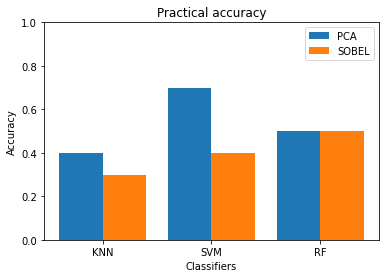

In [14]:
# Plot the practical accuracy of each classifier/ feature extraction method

X = ['KNN','SVM','RF'] 
PCA = [0.4,0.7,0.5] 
SOBEL = [0.3,0.4,0.5] 
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, PCA, 0.4, label = 'PCA' ) 
plt.bar(X_axis + 0.2, SOBEL, 0.4, label = 'SOBEL') 

plt.ylim(0, 1)  

plt.xticks(X_axis, X) 
plt.xlabel("Classifiers") 
plt.ylabel("Accuracy") 
plt.title("Practical accuracy") 
plt.legend() 
plt.show() 

In [15]:
# Calculate Confusion Matrix
conf_matrix_KNN_PCA = confusion_matrix(y_test, pca_knn_predictions)

# Display Confusion Matrix as a table
headers = ['Predict/true'] + [str(i) for i in range(10)]   
conf_matrix_with_headers = np.row_stack((headers, np.column_stack(([f'{i}' for i in range(10)], conf_matrix_KNN_PCA[:10, :10]))))

confusion_table = tabulate(conf_matrix_with_headers, tablefmt="grid", showindex=False, stralign="center")
print("Confusion Matrix:")
print(confusion_table)


Confusion Matrix:
+--------------+----+----+----+----+----+----+----+----+----+----+
| Predict/true |  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      0       | 24 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      1       |  0 | 22 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      2       |  0 |  0 | 20 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      3       |  0 |  1 |  0 | 18 |  0 |  1 |  0 |  1 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      4       |  0 |  0 |  0 |  0 | 24 |  0 |  0 |  0 |  0 |  1 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      5       |  0 |  0 |  0 |  0 |  0 | 23 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+---

In [16]:
num_categories = conf_matrix_KNN_PCA.shape[0]

metrics = {}

for i in range(num_categories):
    TP = conf_matrix_KNN_PCA[i, i]
    FN = np.sum(conf_matrix_KNN_PCA[i, :]) - TP
    FP = np.sum(conf_matrix_KNN_PCA[:, i]) - TP
    TN = np.sum(conf_matrix_KNN_PCA) - TP - FN - FP

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)

    metrics[i] = {"Sensitivity": sensitivity,
                  "Specificity": specificity,
                  "Precision": precision,
                  "Recall": recall,
                  "F1-score": f1_score}
print("KNN-PCA-Sensitivity: ",sensitivity)
print("KNN-PCA-Specificity: ",specificity)
print("KNN-PCA-Precision: ",precision)
print("KNN-PCA-Recall: ",recall)
print("KNN-PCA-F1-score: ",f1_score)

KNN-PCA-Sensitivity:  0.6666666666666666
KNN-PCA-Specificity:  0.9888268156424581
KNN-PCA-Precision:  0.625
KNN-PCA-Recall:  0.6666666666666666
KNN-PCA-F1-score:  0.6451612903225806


In [17]:
# Calculate Confusion Matrix
conf_matrix_KNN_SOBEL = confusion_matrix(y_test, sobel_knn_predictions)

# Display Confusion Matrix as a table
headers = ['Predict/true'] + [str(i) for i in range(10)]   
conf_matrix_with_headers = np.row_stack((headers, np.column_stack(([f'{i}' for i in range(10)], conf_matrix_KNN_SOBEL[:10, :10]))))

confusion_table = tabulate(conf_matrix_with_headers, tablefmt="grid", showindex=False, stralign="center")
print("Confusion Matrix:")
print(confusion_table)

Confusion Matrix:
+--------------+----+----+----+----+----+----+----+----+----+----+
| Predict/true |  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      0       | 26 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      1       |  0 | 21 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      2       |  0 |  4 | 19 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      3       |  0 |  3 |  0 | 16 |  0 |  0 |  0 |  2 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      4       |  0 |  4 |  0 |  0 | 24 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      5       |  0 |  0 |  0 |  1 |  0 | 22 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+---

In [18]:
num_categories = conf_matrix_KNN_SOBEL.shape[0]

metrics = {}

for i in range(num_categories):
    TP = conf_matrix_KNN_SOBEL[i, i]
    FN = np.sum(conf_matrix_KNN_SOBEL[i, :]) - TP
    FP = np.sum(conf_matrix_KNN_SOBEL[:, i]) - TP
    TN = np.sum(conf_matrix_KNN_SOBEL) - TP - FN - FP

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)

    metrics[i] = {"Sensitivity": sensitivity,
                  "Specificity": specificity,
                  "Precision": precision,
                  "Recall": recall,
                  "F1-score": f1_score}
print("KNN-SOBEL-Sensitivity",sensitivity)
print("KNN-SOBEL-Specificity",specificity)
print("KNN-SOBEL-Precision",precision)
print("KNN-SOBEL-Recall",recall)
print("KNN-SOBEL-F1-score",f1_score)

KNN-SOBEL-Sensitivity 0.5666666666666667
KNN-SOBEL-Specificity 0.9962756052141527
KNN-SOBEL-Precision 0.8095238095238095
KNN-SOBEL-Recall 0.5666666666666667
KNN-SOBEL-F1-score 0.6666666666666666


In [19]:
# Calculate Confusion Matrix
conf_matrix_SVM_PCA = confusion_matrix(y_test, pca_svm_predictions)

# Display Confusion Matrix as a table
headers = ['Predict/true'] + [str(i) for i in range(10)]   
conf_matrix_with_headers = np.row_stack((headers, np.column_stack(([f'{i}' for i in range(10)], conf_matrix_SVM_PCA[:10, :10]))))

confusion_table = tabulate(conf_matrix_with_headers, tablefmt="grid", showindex=False, stralign="center")
print("Confusion Matrix:")
print(confusion_table)

Confusion Matrix:
+--------------+----+----+----+----+----+----+----+----+----+----+
| Predict/true |  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      0       | 25 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      1       |  0 | 22 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      2       |  0 |  0 | 25 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      3       |  0 |  0 |  0 | 19 |  0 |  1 |  0 |  0 |  1 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      4       |  0 |  0 |  0 |  0 | 28 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      5       |  0 |  0 |  0 |  0 |  0 | 24 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+---

In [20]:
num_categories = conf_matrix_SVM_PCA.shape[0]

metrics = {}

for i in range(num_categories):
    TP = conf_matrix_SVM_PCA[i, i]
    FN = np.sum(conf_matrix_SVM_PCA[i, :]) - TP
    FP = np.sum(conf_matrix_SVM_PCA[:, i]) - TP
    TN = np.sum(conf_matrix_SVM_PCA) - TP - FN - FP

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)

    metrics[i] = {"Sensitivity": sensitivity,
                  "Specificity": specificity,
                  "Precision": precision,
                  "Recall": recall,
                  "F1-score": f1_score}
print("SVM-PCA-Sensitivity: ",sensitivity)
print("SVM-PCA-Specificity: ",specificity)
print("SVM-PCA-Precision: ",precision)
print("SVM-PCA-Recall: ",recall)
print("SVM-PCA-F1-score: ",f1_score)

SVM-PCA-Sensitivity:  0.8
SVM-PCA-Specificity:  0.9953445065176909
SVM-PCA-Precision:  0.8275862068965517
SVM-PCA-Recall:  0.8
SVM-PCA-F1-score:  0.8135593220338982


In [21]:
# Calculate Confusion Matrix
conf_matrix_SVM_SOBEL = confusion_matrix(y_test, sobel_svm_predictions)

# Display Confusion Matrix as a table
headers = ['Predict/true'] + [str(i) for i in range(10)]   
conf_matrix_with_headers = np.row_stack((headers, np.column_stack(([f'{i}' for i in range(10)], conf_matrix_SVM_SOBEL[:10, :10]))))

confusion_table = tabulate(conf_matrix_with_headers, tablefmt="grid", showindex=False, stralign="center")
print("Confusion Matrix:")
print(confusion_table)

Confusion Matrix:
+--------------+----+----+----+----+----+----+----+----+----+----+
| Predict/true |  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  8 |  9 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      0       | 25 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      1       |  0 | 22 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      2       |  0 |  0 | 21 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      3       |  0 |  0 |  0 | 18 |  0 |  0 |  0 |  1 |  1 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      4       |  0 |  0 |  0 |  0 | 28 |  0 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+----+----+----+----+----+
|      5       |  0 |  0 |  0 |  0 |  0 | 22 |  0 |  0 |  0 |  0 |
+--------------+----+----+----+----+----+---

In [22]:
num_categories = conf_matrix_SVM_SOBEL.shape[0]

metrics = {}

for i in range(num_categories):
    TP = conf_matrix_SVM_SOBEL[i, i]
    FN = np.sum(conf_matrix_SVM_SOBEL[i, :]) - TP
    FP = np.sum(conf_matrix_SVM_SOBEL[:, i]) - TP
    TN = np.sum(conf_matrix_SVM_SOBEL) - TP - FN - FP

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)

    metrics[i] = {"Sensitivity": sensitivity,
                  "Specificity": specificity,
                  "Precision": precision,
                  "Recall": recall,
                  "F1-score": f1_score}
print("SVM-SOBEL-Sensitivity: ",sensitivity)
print("SVM-SOBEL-Specificity: ",specificity)
print("SVM-SOBEL-Precision: ",precision)
print("SVM-SOBEL-Recall: ",recall)
print("SVM-SOBEL-F1-score: ",f1_score)

SVM-SOBEL-Sensitivity:  0.8666666666666667
SVM-SOBEL-Specificity:  0.994413407821229
SVM-SOBEL-Precision:  0.8125
SVM-SOBEL-Recall:  0.8666666666666667
SVM-SOBEL-F1-score:  0.8387096774193549


# Alternative Metrics

In [17]:
# loop through each case and save all results in a list
# kernel: [rbf, poly]
# C: [10, 100]

svm_x = [10,100]
svm_sobel_y = []
svm_pca_y = []
for i in svm_x:
    classifier = SVC(kernel='rbf', probability=True, C=i)
    classifier.fit(x_train_sobel, y_train)
    predictions = classifier.predict(x_test_sobel)
    accuracy = accuracy_score(y_test, predictions)
    svm_sobel_y.append(accuracy)
for i in svm_x:
    classifier = SVC(kernel='poly', probability=True, C=i)
    classifier.fit(x_train_sobel, y_train)
    predictions = classifier.predict(x_test_sobel)
    accuracy = accuracy_score(y_test, predictions)
    svm_sobel_y.append(accuracy)

for i in svm_x:
    classifier = SVC(kernel='rbf', probability=True,C=i)
    classifier.fit(X_train_pca, y_train)
    predictions = classifier.predict(X_test_pca)
    accuracy = accuracy_score(y_test, pca_svm_predictions)
    svm_pca_y.append(accuracy)
for i in svm_x:
    classifier = SVC(kernel='poly', probability=True,C=i)
    classifier.fit(X_train_pca, y_train)
    predictions = classifier.predict(X_test_pca)
    accuracy = accuracy_score(y_test, pca_svm_predictions)
    svm_pca_y.append(accuracy)



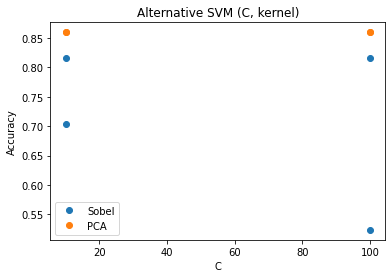

In [19]:
x= flatten_image([svm_x,svm_x])
plt.plot(x, svm_sobel_y, label = "Sobel", marker = 'o', linestyle = "none") 
plt.plot(x,svm_pca_y , label = "PCA", marker = 'o', linestyle = "none") 
plt.xlabel("C") 
plt.ylabel("Accuracy") 
plt.title("Alternative SVM (C, kernel)") 
plt.legend() 
plt.show()


In [10]:
# loop through each case and save all results in a list
# K: [5,9,15,19]

knn_x = [5,9,15,19]
knn_sobel_y = []
knn_pca_y = []

for i in knn_x:
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(x_train_sobel, y_train)
    predictions = classifier.predict(x_test_sobel)
    accuracy = accuracy_score(y_test, predictions)
    knn_sobel_y.append(accuracy)
for i in knn_x:
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(X_train_pca, y_train)
    predictions = classifier.predict(X_test_pca)
    accuracy = accuracy_score(y_test, predictions)
    knn_pca_y.append(accuracy)


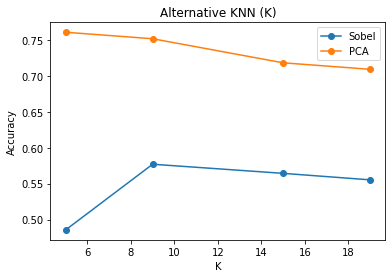

In [12]:
plt.plot(knn_x, knn_sobel_y, label = "Sobel", marker = 'o')
plt.plot(knn_x, knn_pca_y, label = "PCA", marker = 'o')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Alternative KNN (K)")
plt.legend()
plt.show()

In [14]:
# loop through each case and save all results in a list
# n_estimators: [100,140,160,180]

rf_x = [100,140,160,180]
rf_sobel_y = []
rf_pca_y = []

for i in rf_x:
    classifier = RandomForestClassifier(n_estimators=i, random_state=42)
    classifier.fit(x_train_sobel, y_train)
    predictions = classifier.predict(x_test_sobel)
    accuracy = accuracy_score(y_test, predictions)
    rf_sobel_y.append(accuracy)
for i in rf_x:
    classifier = RandomForestClassifier(n_estimators=i, random_state=42)
    classifier.fit(X_train_pca, y_train)
    predictions = classifier.predict(X_test_pca)
    accuracy = accuracy_score(y_test, predictions)
    rf_pca_y.append(accuracy)


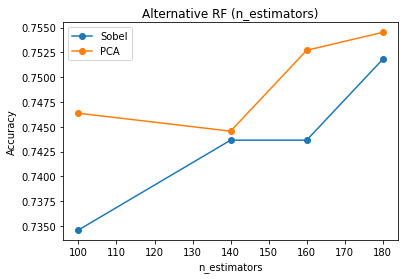

In [15]:
plt.plot(rf_x, rf_sobel_y, label = "Sobel", marker = 'o')
plt.plot(rf_x, rf_pca_y, label = "PCA", marker = 'o')
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("Alternative RF (n_estimators)")
plt.legend()
plt.show()